### Library Imports

In [2]:
import numpy as np
import seaborn as sns
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

### Initializing the values

In [3]:
t_space: range = range(0,201) # Time space
s_space: range = range(0,51) # State space
f: int = 10 # frieght value
i_space: range = range(0,2) # Event space
a_space: range = range(5,405,5) # Action space
T_final = 200

### Defining Utility Functions

In [4]:
def RewardsRt(a:int, i:int, s: int) -> int:
    '''
    Find the new state given the previous state and the event
    @param a: price for a ticket
    @param i: tickets to sell
    @param s: total tickets at time t
    return: revenue generated by selling i tickets
    '''
    return a*min(i,s)

def StateSt(s:int, i: int) -> int:
    '''
    Find the new state given the previous state and the event
    @param s: total tickets
    @param i: ticket to sell
    return: max(0,s-i)
    '''
    return max(0,s-i)

def FinalReward(s:int,f:int = 10) -> float:
    '''
    Returns the net price of remaining tickets at final state, considering we sell the remaining tickets at a const price
    Freight is the optimal action itself.
    '''
    return f*s

def Probabilities(action: int, time: int) -> tuple:
    """
    :param action: the chosen action (Ticket Price)
    :param time: timestamp
    :return: probability for selling ticked for price a and for not selling ticket
    """
    p_1 = (1 - (action / 400)) * ((1 + time) / 200)  # T
    p_0 = 1 - p_1
    return p_0, p_1

def heat_plot(arr: np.array,x_title:str,y_title:str,title:str): 
    fig, ax = plt.subplots(figsize = (9,3))

    # Create heatmap
    heatmap = ax.pcolor(arr, cmap='Oranges')

    # Set x-axis ticks to action indices
    ax.set_xticks(range(0,len(t_space)+1,20), minor=False)

    # Set y-axis ticks to state indices
    ax.set_yticks(range(0,len(s_space)+1,10), minor=False)

    # Add colorbar
    cbar = plt.colorbar(heatmap)

    # Add axis labels
    ax.set_xlabel(x_title)
    ax.set_title(title)
    ax.set_ylabel(y_title)

    plt.show()

### Backward Induction for Finite MDP

In [5]:
def OptimalValAction(s:int, t:int,a_space:range,i_space:range,rf:tuple):
    max_val: float = 0.0
    opt_a:int = 0
    for a in a_space:
        inter_val: float = 0.0
        action_prob: tuple = Probabilities(a,t)
        for i in i_space:
            inter_val += action_prob[i]*(RewardsRt(a,i,s) + rf[i])
        
        if inter_val >= max_val:
            max_val = inter_val
            opt_a = a
    return opt_a,max_val

def BInductionTable(T:range,S:range,f:int,a_space:range,i_space:range):
    V = [[0 for t in range(len(T)+1)] for s in S]
    A = [[0 for t in range(len(T)+1)] for s in S]
    for t in T.__reversed__():
        for s in S:
            if t<T[-1]:
                r_0 = V[s][t+1] # The value in the same state at t+1
                r_1 = V[s-1][t+1] if s>0 else 0 # The value if 1 ticket is sold at t+1, and if we are left with no tickets 0 is returned
                #print(t,s,r_0,r_1)
                A[s][t],V[s][t] = OptimalValAction(s,t,a_space,i_space,(r_0,r_1))
            else:
                A[s][t],V[s][t] = a_space[0],FinalReward(f,s) # To sell all the remaining tickets
    return np.array(A),np.array(V)

### Visualizing the Optimal Values and Optimal Policy

In [6]:
opt_a,opt_values = BInductionTable(t_space,s_space,f,a_space,i_space)

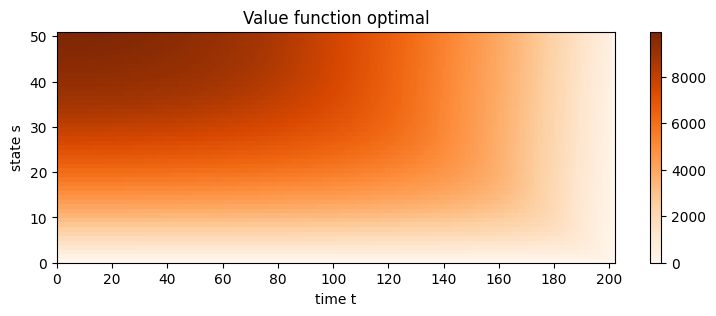

In [7]:
heat_plot(opt_values,x_title='time t',y_title='state s',title='Value function optimal')

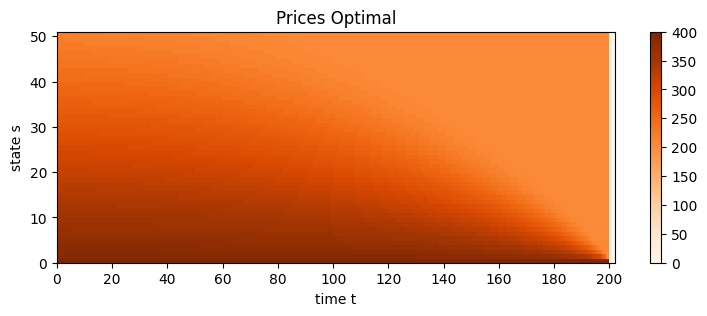

In [8]:
heat_plot(opt_a,x_title='time t',y_title='state s',title='Prices Optimal')

In [9]:
# show the expected value for Time 0 and State 50
print(f"Expected value for state 50 time 0: {opt_values[50][0]}")
print(f"Best Action for state 50 time 0: {opt_a[50][0]}")

Expected value for state 50 time 0: 9945.639297690372
Best Action for state 50 time 0: 220


Text(0, 0.5, 'Expected Rewards')

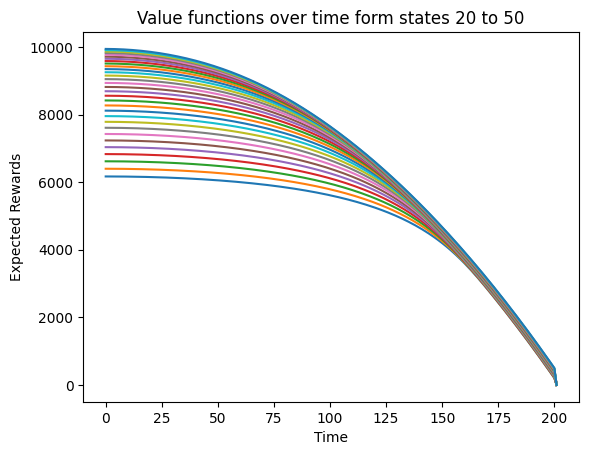

In [10]:
for i in range(20, 51, 1):
    plt.plot(opt_values[i])

plt.title("Value functions over time form states 20 to 50")
plt.xlabel("Time")
plt.ylabel("Expected Rewards")

### Simulate 1000 Runs using the optimal policy obtained in task 2

In [11]:
final_rewards: list = []
initial_state:int = 50
for i in range(1000):
    current_state: int = initial_state
    reward: int = 0
    for t in t_space:
        best_action: int = opt_a[current_state][t]
        #print(best_action)
        _,p_1 = Probabilities(action=best_action, time=t)
        event: int = bernoulli.rvs(p_1,size = 1)[0]
        reward += RewardsRt(a=best_action,i = event,s = current_state)
        #print(reward)
        current_state = StateSt(i=event, s=current_state)

    final_rewards.append(reward)

### Inspecting the Results

Text(0, 0.5, 'Total Rewards')

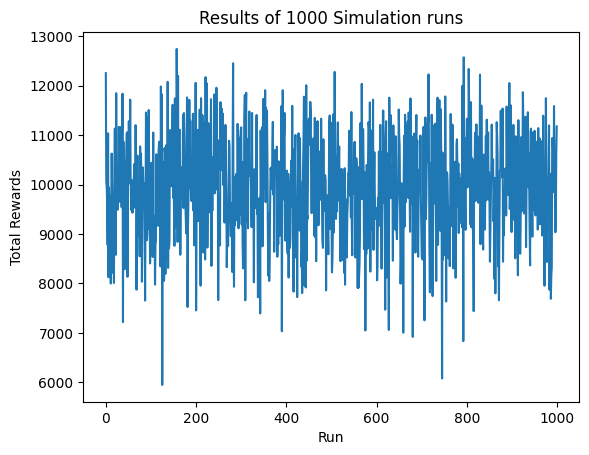

In [12]:
plt.plot(final_rewards)
plt.title("Results of 1000 Simulation runs")
plt.xlabel("Run")
plt.ylabel("Total Rewards")

Text(0, 0.5, 'Occurrences')

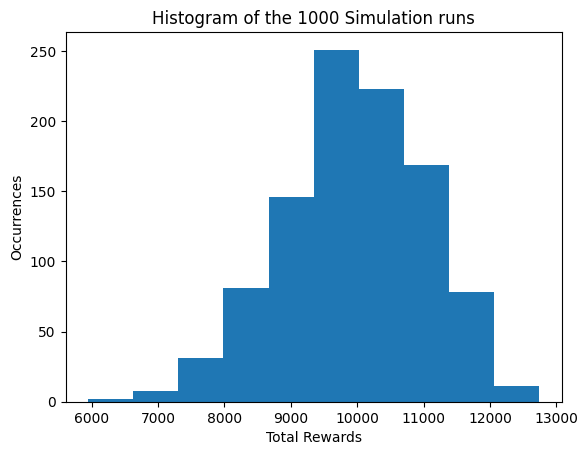

In [13]:
plt.hist(final_rewards, density=False)
plt.title("Histogram of the 1000 Simulation runs")
plt.xlabel("Total Rewards")
plt.ylabel("Occurrences")

Text(0, 0.5, 'Probability')

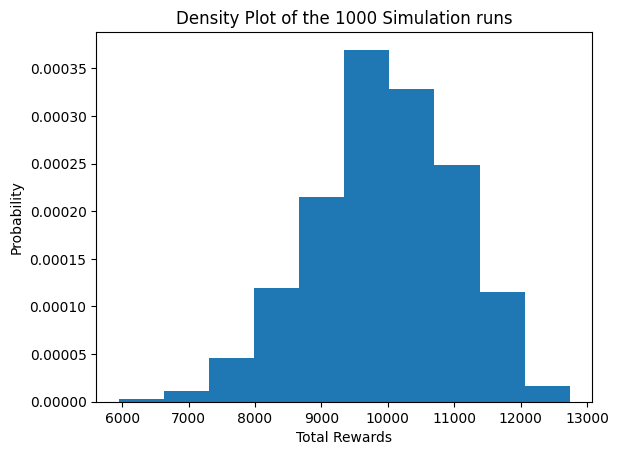

In [14]:
plt.hist(final_rewards, density=True)
plt.title("Density Plot of the 1000 Simulation runs")
plt.xlabel("Total Rewards")
plt.ylabel("Probability")